# Problem statement

Sudden user engagement dip in August requires investigation.

# Possible causes of retention drop

1. Holiday (change of schedule)
2. Change in interface/usability
3. A new competitor has popped up
4. Change in cost of subscription
5. No new features have been added in a long time
6. Server update
7. Less signups overall 


# Digging into the data

Importing all necessary packages

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

Connecting to the database

In [2]:
conn = sqlite3.connect('case-study.db')
c = conn.cursor()

Exploring users, events, emails data table

In [3]:
pd.read_sql('''
SELECT * FROM users
''', conn).head()

,user_id,created_at,company_id,language,activated_at,state
0,0,2013-01-01 20:59:39,5737,english,2013-01-01 21:01:07,active
1,1,2013-01-01 13:07:46,28,english,None,pending
2,2,2013-01-01 10:59:05,51,english,None,pending
3,3,2013-01-01 18:40:36,2800,german,2013-01-01 18:42:02,active
4,4,2013-01-01 14:37:51,5110,indian,2013-01-01 14:39:05,active


In [34]:
events = pd.read_sql('''
SELECT * FROM events
''', conn)

In [5]:
pd.read_sql('''
SELECT Distinct event_type FROM events
''', conn)

,event_type
0,engagement
1,signup_flow


In [6]:
pd.read_sql('''
SELECT Distinct event_name FROM events
''', conn)

,event_name
0,login
1,home_page
2,like_message
3,view_inbox
4,search_run
5,send_message
6,search_autocomplete
7,search_click_result_10
8,create_user
9,enter_email


In [7]:
pd.read_sql('''
SELECT * FROM events
WHERE event_name='complete_signup'
''', conn).head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,11768,2014-05-01 08:03:12,signup_flow,complete_signup,France,macbook pro,3
1,11770,2014-05-01 06:08:50,signup_flow,complete_signup,Japan,iphone 5s,3
2,11775,2014-05-01 16:38:06,signup_flow,complete_signup,United Kingdom,lenovo thinkpad,2
3,11778,2014-05-01 18:49:49,signup_flow,complete_signup,Indonesia,iphone 4s,3
4,11779,2014-05-01 18:24:54,signup_flow,complete_signup,Germany,samsung galaxy s4,1


### Dive into platform signups

In [8]:
pd.read_sql('''
SELECT * FROM events
WHERE event_name='complete_signup'
''', conn).head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,11768,2014-05-01 08:03:12,signup_flow,complete_signup,France,macbook pro,3
1,11770,2014-05-01 06:08:50,signup_flow,complete_signup,Japan,iphone 5s,3
2,11775,2014-05-01 16:38:06,signup_flow,complete_signup,United Kingdom,lenovo thinkpad,2
3,11778,2014-05-01 18:49:49,signup_flow,complete_signup,Indonesia,iphone 4s,3
4,11779,2014-05-01 18:24:54,signup_flow,complete_signup,Germany,samsung galaxy s4,1


In [9]:
signups = pd.read_sql('''
SELECT strftime('%d', occurred_at) as day,
       strftime('%m', occurred_at) as month,
       strftime('%Y', occurred_at) as year,
       strftime('%W-%Y', occurred_at) as date,
       COUNT(distinct user_id) as count
from events
WHERE event_name='complete_signup'
group by date
''', conn)

In [10]:
engagements = pd.read_sql('''
SELECT strftime('%d', occurred_at) as day,
       strftime('%m', occurred_at) as month,
       strftime('%Y', occurred_at) as year,
       strftime('%W-%Y', occurred_at) as date,
       count(distinct user_id) as count
from events
WHERE event_type='engagement'
group by date
''', conn)

In [11]:
engagements.head()

,day,month,year,date,count
0,02,05,2014,17-2014,701
1,09,05,2014,18-2014,1054
2,15,05,2014,19-2014,1094
3,20,05,2014,20-2014,1147
4,28,05,2014,21-2014,1113


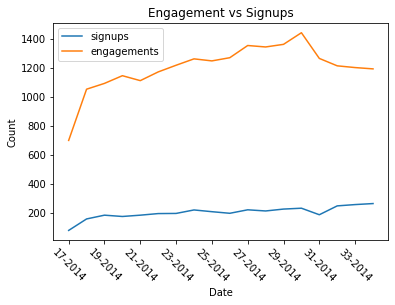

In [25]:
plt.figure()
plt.plot(signups['date'],signups['count'],label='signups')
plt.plot(engagements['date'], engagements['count'],label='engagements')
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(signups['date'][::2], rotation=-45)
plt.legend()
plt.title("Engagement vs Signups")
plt.show()


In [28]:
signups['pct_change'] = signups['count'].pct_change()
engagements['pct_change'] = engagements['count'].pct_change()

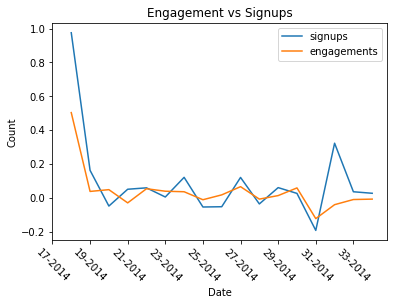

In [31]:
plt.figure()
plt.plot(signups['date'],signups['pct_change'],label='signups')
plt.plot(engagements['date'], engagements['pct_change'],label='engagements')
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(signups['date'][::2], rotation=-45)
plt.legend()
plt.title("Engagement vs Signups")
plt.show()


### Investigate if retention drop caused by change to specific devices

In [42]:
events['device'].unique()

array(['dell inspiron notebook', 'iphone 5', 'iphone 4s',
       'windows surface', 'macbook air', 'iphone 5s', 'macbook pro',
       'kindle fire', 'ipad mini', 'nexus 7', 'nexus 5',
       'samsung galaxy s4', 'lenovo thinkpad', 'samsumg galaxy tablet',
       'acer aspire notebook', 'asus chromebook', 'htc one',
       'nokia lumia 635', 'samsung galaxy note', 'acer aspire desktop',
       'mac mini', 'hp pavilion desktop', 'dell inspiron desktop',
       'ipad air', 'amazon fire phone', 'nexus 10'], dtype=object)

In [43]:
device_dict = {'dell inspiron notebook': 'computer', 
               'iphone 5': 'mobile', 
               'iphone 4s': 'mobile',
               'windows surface': 'tablet',
               'macbook air': 'computer',
               'iphone 5s': 'mobile',
               'macbook pro': 'computer',
               'kindle fire': 'tablet',
               'ipad mini': 'tablet',
               'nexus 7': 'tablet',
               'nexus 5': 'tablet',
               'samsung galaxy s4': 'mobile',
               'lenovo thinkpad': 'computer',
               'samsumg galaxy tablet': 'tablet',
               'acer aspire notebook': 'computer',
               'asus chromebook': 'computer',
               'htc one': 'mobile',
               'nokia lumia 635': 'mobile',
               'samsung galaxy note': 'mobile',
               'acer aspire desktop': 'computer',
               'mac mini': 'computer',
               'hp pavilion desktop': 'computer',
               'dell inspiron desktop': 'computer',
               'ipad air': 'tablet',
               'amazon fire phone': 'mobile', 
               'nexus 10': 'tablet'}

In [ ]:
'iPhone 14 Pro'

In [45]:
events['device_type'] = events['device'].map(device_dict)

In [51]:
events['occurred_at'] = pd.to_datetime(events['occurred_at'])

In [62]:
events['week'] = events['occurred_at'].dt.strftime('%W')
events['count'] = 1

In [65]:
grouped_events = events.groupby(['week','device_type']).count().reset_index()

In [68]:
grouped_events_df = grouped_events[['week','device_type','count']]

In [70]:
import plotly.express as px

fig = px.line(grouped_events_df, x='week', y='count', color='device_type')
fig.show()

In [71]:
grouped_events_df.head()

,week,device_type,count
0,17,computer,4831
1,17,mobile,2673
2,17,tablet,1645
3,18,computer,10635
4,18,mobile,4750


In [72]:
device_table = pd.pivot_table(grouped_events_df, values='count', index=['week'], columns=['device_type'])

In [73]:
device_table

device_type,computer,mobile,tablet
week,,,
17,4831,2673,1645
18,10635,4750,3031
19,10072,4744,3191
20,10655,4950,3240
21,10207,4859,3105
22,11083,4968,3600
23,10731,5273,3302
24,11199,5274,3639
25,11119,5456,3365
